<a href="https://www.kaggle.com/code/sanidhyapokhrail/nlpproject?scriptVersionId=177526015" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2


In [2]:
def get_dataset(subset):
    return tf.keras.utils.image_dataset_from_directory(
        "/kaggle/input/animal-dataset/Animal sample",
        
        class_names=None,
        color_mode='rgb',
        batch_size=32,
        image_size=(64, 64),
        shuffle=True,
        seed=1,
        validation_split=0.2,
        subset=subset
    )
train_data = get_dataset('training')
val_data = get_dataset('validation')
labels = os.listdir("/kaggle/input/animal-dataset/Animal sample")
labels.sort()
print(labels)
train_data


Found 5836 files belonging to 12 classes.
Using 4669 files for training.
Found 5836 files belonging to 12 classes.
Using 1167 files for validation.
['Bird-samples', 'Bull-samples', 'Cat-samples', 'Crab-samples', 'Crocodile-samples', 'Deer-samples', 'Dog-samples', 'Elephant-samples', 'Moose-samples', 'Penguin-samples', 'Wolf-samples', 'snail-samples']


<BatchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

Training Dataset


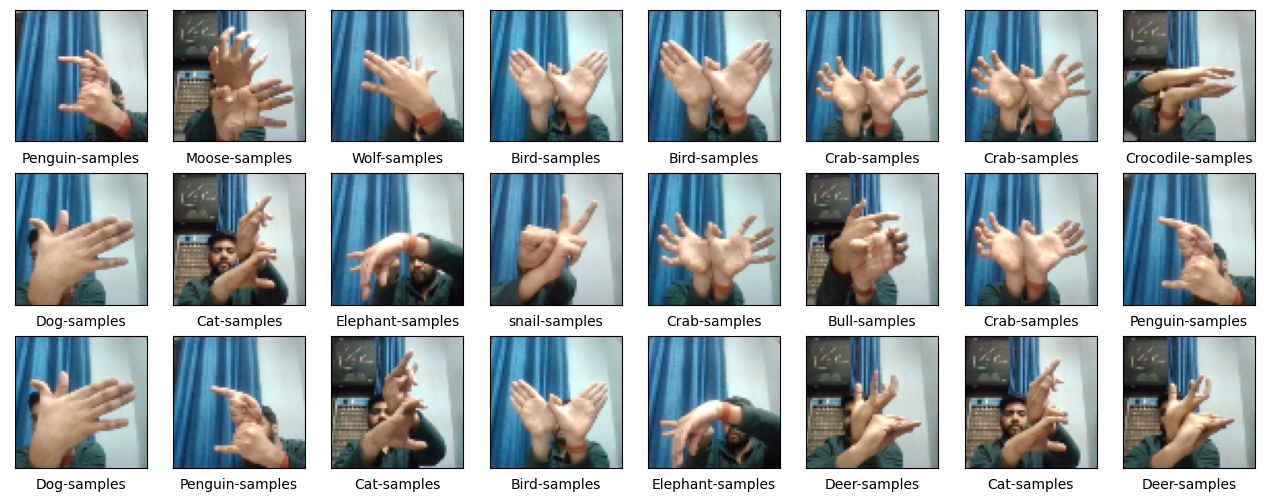

Validation Dataset


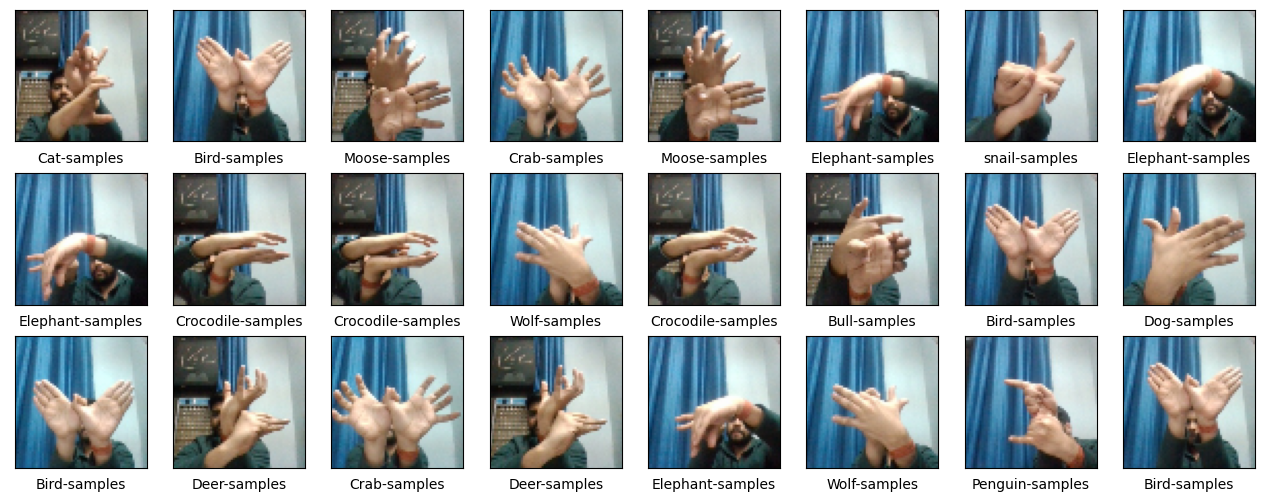

In [3]:
def preview_dataset(dataset, nrow=3, ncol=8):
    plt.figure(figsize=(ncol*2,nrow*2))
    i = 0
    for (image, label) in train_data.take(nrow*ncol):
        image = image.numpy()[0].reshape((64,64,3))/255.0
        plt.subplot(nrow,ncol,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image)
        plt.xlabel(labels[label[0].numpy()])
        i += 1
    plt.show()
print("Training Dataset")
preview_dataset(train_data)
print("Validation Dataset")
preview_dataset(val_data)

In [4]:
model = tf.keras.Sequential()

resnet_model = tf.keras.applications.resnet_v2.ResNet152V2(
    include_top=False,
    input_shape=(64,64,3),
    pooling='avg',
    classes=12,
    weights='imagenet'
)

234545216/234545216 [==============================] - 2s 0us/step


In [5]:
# preprocess. i do this from the docs
i = tf.keras.layers.Input((64,64,3), dtype='uint8')
x = tf.cast(i, tf.float32)
x = tf.keras.applications.resnet_v2.preprocess_input(x)
x = resnet_model(x)
resnet_model = tf.keras.Model(inputs=[i], outputs=[x])

model.add(resnet_model)

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2)) # drop some nodes to prevent overfitting
model.add(tf.keras.layers.Dense(12, activation='softmax'))

model.summary()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 2048)              58331648  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 12)                1548      
                                                                 
Total params: 58,595,468
Trainable params: 58,451,724
Non-trainable params: 143,744
_________________________________________________________________


In [6]:
# used to prevent overfitting as epochs progress
# i use val_loss to monitor overfitting
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=3,
    callbacks=[callback]
)


Epoch 1/3
146/146 [==============================] - 917s 6s/step - loss: 0.2107 - accuracy: 0.9518 - val_loss: 3.4696 - val_accuracy: 0.7566
Epoch 2/3
146/146 [==============================] - 835s 6s/step - loss: 0.1515 - accuracy: 0.9790 - val_loss: 12.3726 - val_accuracy: 0.6675
Epoch 3/3
146/146 [==============================] - 817s 6s/step - loss: 0.3156 - accuracy: 0.9717 - val_loss: 146381.6094 - val_accuracy: 0.1011


In [7]:
_ = model.evaluate(val_data)

37/37 [==============================] - 24s 649ms/step - loss: 146381.6094 - accuracy: 0.1011


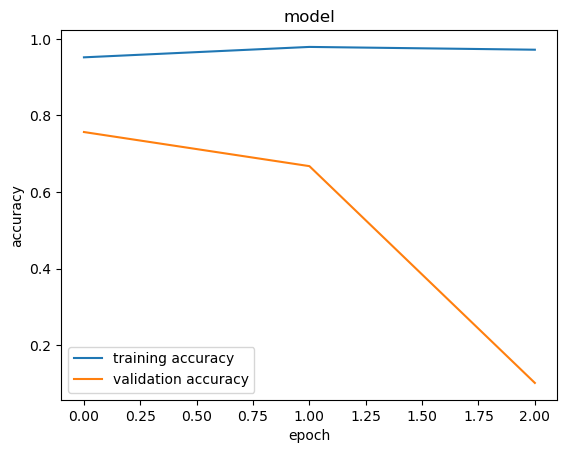

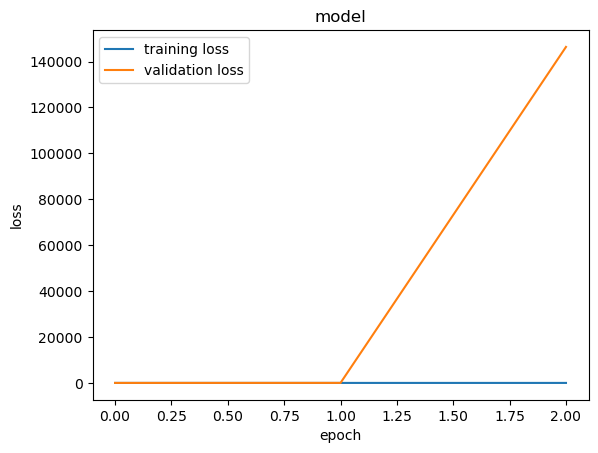

In [8]:
def plot_training_graph(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training accuracy', 'validation accuracy'], loc='best')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training loss', 'validation loss'], loc='best')
    plt.show()
plot_training_graph(history)


In [9]:

#import cv2

#cam = cv2.VideoCapture(2)

#while True:
#    check, frame = cam.read()

#    cv2.imshow('webcam', frame)

#    key = cv2.waitKey(1)
#    if key == 27:
#        break
#
#cam.release()
#cv2.destroyAllWindows()